In [1]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

In [2]:
def get_points(corner_list, depth_map):
    """
    Convert the detected corners to 3D points using the depth map.
    """
    s = 5000.0
    k = np.array([[520.0, 0, 319.5], [0, 525.0, 239.5], [0, 0, 1]])
    kinv = np.linalg.inv(k)
    corner_3d = []
    for corner in corner_list:
        x, y = corner
        d = depth_map[y, x] / s
        if np.all(d) == 0:
            continue
        p = np.dot(kinv, np.array([x, y, 1]))
        p *= d
        corner_3d.append(p)
    return np.array(corner_3d)

In [3]:
def Part_1(path):
    # Load the image
    img = cv2.imread(path[0])
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Compute the x- and y-derivatives of the image using a 3x3 Sobel filter
    Ix = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute the second-order derivatives of the image using a 3x3 Sobel filter
    Ixx = cv2.Sobel(Ix, cv2.CV_64F, 1, 0, ksize=3)
    Iyy = cv2.Sobel(Iy, cv2.CV_64F, 0, 1, ksize=3)
    Ixy = cv2.Sobel(Ix, cv2.CV_64F, 0, 1, ksize=3)
    
    # Apply Gaussian smoothing to the second-order derivatives using a 5x5 filter
    sigma = 1.5
    ksize = int(2*np.ceil(3*sigma)+1)
    kx = cv2.getGaussianKernel(ksize, sigma)
    ky = cv2.getGaussianKernel(ksize, sigma)
    k = np.multiply(kx, np.transpose(ky))
    Ixx = cv2.filter2D(Ixx, -1, k)
    Iyy = cv2.filter2D(Iyy, -1, k)
    Ixy = cv2.filter2D(Ixy, -1, k)
    
    # Compute the Harris corner response function R
    k = 0.04  # Harris corner constant
    R = (Ixx * Iyy - Ixy ** 2) - k * (Ixx + Iyy) ** 2
    
    # Apply non-maximum suppression on the responses of the Harris operator in 3x3 windows
    window_size = 3
    local_maxima = np.zeros_like(R, dtype=np.uint8)
    for y in range(window_size//2, R.shape[0]-window_size//2):
        for x in range(window_size//2, R.shape[1]-window_size//2):
            if R[y, x] == np.max(R[y-window_size//2:y+window_size//2+1, x-window_size//2:x+window_size//2+1]):
                local_maxima[y, x] = 255
    
    # Pick the 100 corners with the strongest response
    corners = []
    for y in range(local_maxima.shape[0]):
        for x in range(local_maxima.shape[1]):
            if local_maxima[y, x] != 0:
                corners.append((x, y))
    corners = sorted(corners, key=lambda x: R[x[1], x[0]], reverse=True)[:100]
    
    # Draw circles around the detected corners
    for corner in corners:
        cv2.circle(img, corner, radius=3, color=(0, 255, 0), thickness=-1)

    # Display the result
    plt.imshow(img)
    return get_points(corners, cv2.imread(path[1])), corners

In [4]:
def rank_transform(img):
    """
    Compute the rank transform of the given 3D image using a 5x5x5 window.
    """
    rank = np.zeros_like(img)
    for z in range(2, img.shape[0]-2):
        for y in range(2, img.shape[1]-2):
            for x in range(2, img.shape[2]-2):
                window = img[z-2:z+3, y-2:y+3, x-2:x+3].ravel()
                rank[z, y, x] = np.sum(window < img[z, y, x])
    return rank

In [5]:
def find_matches(img1, img2, corners):
    """
    Find putative matches between the corners of images
    """
    # Compute rank transform in 5x5 windows for all images
    rank1 = rank_transform(img1)
    rank2 = rank_transform(img2)
    
    # Compute distances between every corner of image 2 to every corner of image 1 and 3
    dist1 = cv2.matchTemplate(rank2.astype(np.float32), rank1.astype(np.float32), cv2.TM_SQDIFF_NORMED)
    
    # Find top 10 matches for image pair
    matches = []
    for idx, corner in enumerate(corners):
        x, y = corner

        # Find best match in image
        min_val1, _, min_loc1, _ = cv2.minMaxLoc(dist1[y:y+1, x:x+1])
        if min_val1 < 0.1:
            matches.append(cv2.DMatch(idx, min_loc1[0], min_val1))

    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)[:10]
    return matches

In [6]:
from scipy.spatial.transform import Rotation

def ransac_rigid_transform(point_cloud1, point_cloud2, matches, num_iterations=100, threshold=0.05):
    """
    Use RANSAC to compute a rigid transform between two point clouds
    """
    best_inliers = []
    best_transform = None

    for i in range(num_iterations):
        # Select a random set of point correspondences
        sampled_matches = random.sample(matches, 3)
        points1 = np.array([point_cloud1[match.queryIdx] for match in sampled_matches])
        points2 = np.array([point_cloud2[match.trainIdx] for match in sampled_matches])

        # Compute the rigid transform using the selected correspondences
        transform, _, _ = cv2.estimateAffine3D(points1, points2)
        
        current_inliers = []
        for match in matches:
            point1 = point_cloud1[match.queryIdx]
            point2 = point_cloud2[match.trainIdx]
            point1_transformed = np.dot(transform, np.hstack((point1, 1)).reshape((4, 1)))
            point1_transformed = point1_transformed[:3, 0]
            dist = np.linalg.norm(point1_transformed - point2)
            if dist < threshold:
                current_inliers.append(match)

        # If the current set of inliers is the best we've seen so far, update the best transform
        if len(current_inliers) > len(best_inliers):
            best_inliers = current_inliers
            best_transform = transform
            
    return best_transform

In [7]:
def compute_normals(points):
    """
    Compute the normal of the plane passing through each 3D point using the 3D points in its 7x7 neighborhood.
    """
    normals = []
    for i in range(len(points)):
        # Get the 7x7 neighborhood around the point
        neighborhood = points[max(0, i-3):min(i+4, len(points))]
        if len(neighborhood) < 3:
            # Not enough points to estimate the plane
            normals.append([0, 0, 0])
            continue
        # Compute the centroid of the neighborhood
        centroid = np.mean(neighborhood, axis=0)
        # Compute the covariance matrix of the neighborhood
        covariance = np.cov(neighborhood.T)
        # Compute the eigenvectors and eigenvalues of the covariance matrix
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        # Use the eigenvector corresponding to the smallest eigenvalue as the normal of the plane
        normal = eigenvectors[:, np.argmin(eigenvalues)]
        # Negate the normal if it points away from the centroid
        if np.dot(normal, points[i] - centroid) < 0:
            normal *= -1
        normals.append(normal)
    return np.array(normals)

In [8]:
def get_plane_coeffs(points):
    """
    Compute the plane coefficients for a set of 3D points using SVD.
    """
    # Compute the centroid of the points
    centroid = np.mean(points, axis=0)

    # Center the points around the origin
    centered_points = points - centroid

    # Compute the SVD of the centered points
    _, _, v = np.linalg.svd(centered_points)

    # The normal of the plane is the direction of the smallest singular value
    normal = v[-1]

    # Get the plane equation from the normal and any point on the plane
    d = -np.dot(normal, centroid)
    coeffs = np.concatenate([normal, [d]])

    return coeffs

In [9]:
def fix_normal_direction(normal, plane_coeffs):
    """
    Fix the direction of the normal based on the plane equation coefficients.
    """
    if plane_coeffs[3] < 0:
        return -normal
    else:
        return normal

In [10]:
def store_normals_as_rgb(normals):
    """
    Store the normal of each 3D point in an RGB image and map the elements of the normal to the [0,255] range.
    """
    rgb = np.zeros((normals.shape[0], normals.shape[1], 3), dtype=np.uint8)
    for i in range(normals.shape[0]):
        for j in range(normals.shape[1]):
            n = normals[i, j]
            if np.all(n == 0):
                # For pixels with zero depth, set the normal to [0,0,0]
                rgb[i, j] = [0, 0, 0]
            else:
                # Map the elements of the normal to the [0,255] range
                n /= 2*np.linalg.norm(n)
                n += [0.5, 0.5, 0.5]
                n *= 255
                rgb[i, j] = n.astype(np.uint8)
    return rgb

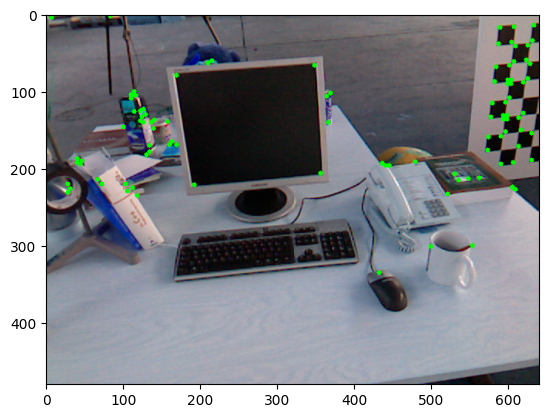

In [11]:
img1 = cv2.imread("problem1/rgb1.png")
point1, corner1 = Part_1(["problem1/rgb1.png", "problem1/depth1.png"])

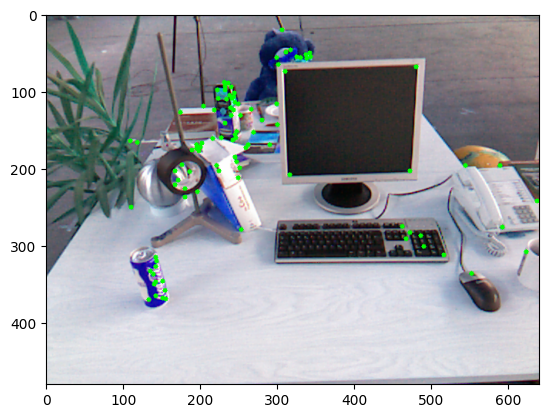

In [12]:
img2 = cv2.imread("problem1/rgb2.png")
point2, corner2  = Part_1(["problem1/rgb2.png", "problem1/depth2.png"])

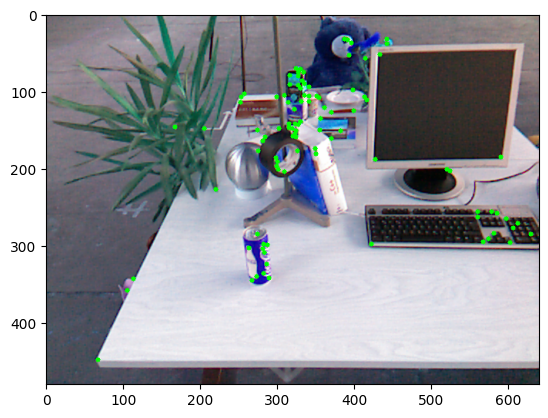

In [13]:
img3 = cv2.imread("problem1/rgb3.png")
point3, corner3 = Part_1(["problem1/rgb3.png", "problem1/depth3.png"])

In [14]:
match1 = find_matches(img1, img2, corner1)
match2 = find_matches(img3, img2, corner3)

In [15]:
test = ransac_rigid_transform(point1, point2, match1)

# Problem 2

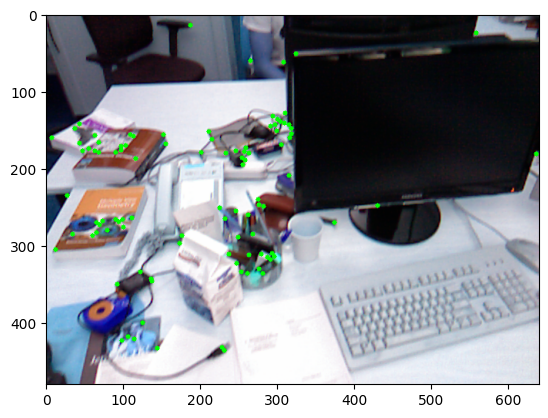

In [16]:
img = cv2.imread("problem2/rgbn.png")
points, corner = Part_1(["problem2/rgbn.png", "problem2/depthn.png"])

In [17]:
normals = compute_normals(points)

In [18]:
rgb = store_normals_as_rgb(normals)

In [19]:
coffes = get_plane_coeffs(points)

In [20]:
normals = fix_normal_direction(normals, coffes)

In [21]:
rgb = store_normals_as_rgb(normals)